In this journal, we aim to train a functioning audio sentiment model. This model would be utilised in an analyser, which can be represented as:

Audio Object -------> Sentiment Analyser ------> Sentiment Object

The file names for each audio file describes various details about the short audio clip that comes with it, including the emotion. We will use emotion attached to train the model.

In [34]:
import os
import random
from fetch_emotion import get_emotion_number, get_emotion_str
import pandas as pd
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Activation
from keras.models import Sequential, Model, load_model
import matplotlib.pyplot as plt

In [36]:
# Set number of threads
tf.config.threading.set_inter_op_parallelism_threads(8)
tf.config.threading.set_intra_op_parallelism_threads(8)

In [37]:
n_labels = 7
path = '../audiofiles'

Here, we want to have all the files available for training. We will skip non-wav files.

In [38]:
file_names = []
for path, _, files in os.walk(path):
    for name in files:
        if name[-3:] == 'wav':
            file_names.append(os.path.join(path, name))

Audio features have to be extracted from each audio sample into a data frame.

In [39]:
# Initialise dataframe with 3 columns for features of name, features and emotion
df = pd.DataFrame(columns=['name', 'feature', 'emotion'])

In [40]:
for i, name in enumerate(file_names):
    # Extract data from audio file     
    X, sample_rate = librosa.load(name, res_type='kaiser_fast', duration=3, sr=22050*2, offset=0.5)
    sample_rate = np.array(sample_rate)
    # Get rand number between -0.4 and 0.4
    rand_shift = random.uniform(-0.4, 0.4)
    # Apply a random time shift
    samples_to_shift = int(len(X) * rand_shift)
    X = np.roll(X, samples_to_shift)
    # Get features of audio data and attach label
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
    # Extract label from name    
    label = get_emotion_number(name)
    df.loc[i] = [name, mfccs, label]

Preprocess into suitable dimensions.

In [41]:
feature_df = pd.DataFrame(df['feature'].values.tolist())
labelled_df = pd.concat([feature_df, df['emotion']], axis=1)
labelled_df = labelled_df.dropna()
shuffled_df = labelled_df.sample(frac=1).reset_index(drop=True)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(shuffled_df.drop('emotion', axis=1), 
                                                    shuffled_df['emotion'], 
                                                    test_size=0.3, 
                                                    random_state=17, 
                                                    shuffle = True)

In [43]:
x_train_exp = np.expand_dims(X_train, axis=2)
x_test_exp = np.expand_dims(X_test, axis=2)

Training the model.

In [44]:
model = Sequential()

# Layer 1
model.add(Conv1D(256, 5, padding='same', input_shape=(x_train_exp.shape[1], 1)))
model.add(Activation('relu'))

# layer 2
model.add(Conv1D(128, 5, padding='same'))
model.add(Activation('relu'))

# Regularisation and Pooling
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=(8)))

# Layer 3
model.add(Conv1D(128, 5, padding='same'))
model.add(Activation('relu'))

# Converge Nodes and conversion to probability distribution
model.add(Flatten())
model.add(Dense(n_labels)) 
model.add(Activation('softmax')) 

opt = keras.optimizers.RMSprop(learning_rate=0.0001, weight_decay=1e-6)

In [45]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [46]:
history = model.fit(x_train_exp, y_train, batch_size=256, epochs=600, validation_data=[x_test_exp, y_test])

Epoch 1/600
7/7 [==============================] - 4s 418ms/step - loss: 5.2320 - accuracy: 0.1707 - val_loss: 2.1246 - val_accuracy: 0.2527
Epoch 2/600
7/7 [==============================] - 2s 266ms/step - loss: 3.6988 - accuracy: 0.1865 - val_loss: 1.8483 - val_accuracy: 0.2595
Epoch 3/600
7/7 [==============================] - 2s 255ms/step - loss: 2.9109 - accuracy: 0.1766 - val_loss: 1.8272 - val_accuracy: 0.2582
Epoch 4/600
7/7 [==============================] - 2s 278ms/step - loss: 2.6675 - accuracy: 0.2051 - val_loss: 1.8926 - val_accuracy: 0.2269
Epoch 5/600
7/7 [==============================] - 2s 267ms/step - loss: 2.4871 - accuracy: 0.1876 - val_loss: 1.8103 - val_accuracy: 0.3016
Epoch 6/600
7/7 [==============================] - 2s 243ms/step - loss: 2.2678 - accuracy: 0.2092 - val_loss: 1.7753 - val_accuracy: 0.2908
Epoch 7/600
7/7 [==============================] - 2s 247ms/step - loss: 2.1918 - accuracy: 0.2296 - val_loss: 1.7241 - val_accuracy: 0.3043
Epoch 8/600
7

Epoch 59/600
7/7 [==============================] - 2s 250ms/step - loss: 1.3215 - accuracy: 0.5152 - val_loss: 1.3835 - val_accuracy: 0.5068
Epoch 60/600
7/7 [==============================] - 2s 251ms/step - loss: 1.2973 - accuracy: 0.5122 - val_loss: 1.3818 - val_accuracy: 0.5027
Epoch 61/600
7/7 [==============================] - 2s 257ms/step - loss: 1.2944 - accuracy: 0.4988 - val_loss: 1.3691 - val_accuracy: 0.5190
Epoch 62/600
7/7 [==============================] - 2s 257ms/step - loss: 1.2830 - accuracy: 0.5245 - val_loss: 1.3834 - val_accuracy: 0.5041
Epoch 63/600
7/7 [==============================] - 2s 249ms/step - loss: 1.2838 - accuracy: 0.5099 - val_loss: 1.3797 - val_accuracy: 0.5245
Epoch 64/600
7/7 [==============================] - 2s 251ms/step - loss: 1.2940 - accuracy: 0.5012 - val_loss: 1.3611 - val_accuracy: 0.5353
Epoch 65/600
7/7 [==============================] - 2s 235ms/step - loss: 1.2558 - accuracy: 0.5286 - val_loss: 1.3669 - val_accuracy: 0.5027
Epoch 

7/7 [==============================] - 2s 241ms/step - loss: 1.0822 - accuracy: 0.5909 - val_loss: 1.2614 - val_accuracy: 0.5584
Epoch 117/600
7/7 [==============================] - 2s 243ms/step - loss: 1.0849 - accuracy: 0.5927 - val_loss: 1.2536 - val_accuracy: 0.5448
Epoch 118/600
7/7 [==============================] - 2s 255ms/step - loss: 1.0640 - accuracy: 0.6090 - val_loss: 1.2103 - val_accuracy: 0.5965
Epoch 119/600
7/7 [==============================] - 2s 244ms/step - loss: 1.0637 - accuracy: 0.6195 - val_loss: 1.1934 - val_accuracy: 0.5938
Epoch 120/600
7/7 [==============================] - 2s 221ms/step - loss: 1.0782 - accuracy: 0.5956 - val_loss: 1.2757 - val_accuracy: 0.5421
Epoch 121/600
7/7 [==============================] - 2s 233ms/step - loss: 1.0897 - accuracy: 0.5874 - val_loss: 1.2345 - val_accuracy: 0.5380
Epoch 122/600
7/7 [==============================] - 2s 248ms/step - loss: 1.0852 - accuracy: 0.5903 - val_loss: 1.2311 - val_accuracy: 0.5693
Epoch 123/600

7/7 [==============================] - 2s 255ms/step - loss: 0.9213 - accuracy: 0.6515 - val_loss: 1.0976 - val_accuracy: 0.6535
Epoch 174/600
7/7 [==============================] - 2s 264ms/step - loss: 0.9336 - accuracy: 0.6556 - val_loss: 1.0861 - val_accuracy: 0.6372
Epoch 175/600
7/7 [==============================] - 2s 245ms/step - loss: 0.9368 - accuracy: 0.6597 - val_loss: 1.0638 - val_accuracy: 0.6793
Epoch 176/600
7/7 [==============================] - 2s 241ms/step - loss: 0.8957 - accuracy: 0.6702 - val_loss: 1.1405 - val_accuracy: 0.5856
Epoch 177/600
7/7 [==============================] - 2s 258ms/step - loss: 0.9271 - accuracy: 0.6626 - val_loss: 1.1029 - val_accuracy: 0.6264
Epoch 178/600
7/7 [==============================] - 2s 246ms/step - loss: 0.9029 - accuracy: 0.6614 - val_loss: 1.1277 - val_accuracy: 0.5951
Epoch 179/600
7/7 [==============================] - 2s 224ms/step - loss: 0.9195 - accuracy: 0.6562 - val_loss: 1.0916 - val_accuracy: 0.6236
Epoch 180/600

7/7 [==============================] - 2s 241ms/step - loss: 0.8086 - accuracy: 0.7139 - val_loss: 0.9891 - val_accuracy: 0.6685
Epoch 231/600
7/7 [==============================] - 2s 243ms/step - loss: 0.8200 - accuracy: 0.6911 - val_loss: 0.9792 - val_accuracy: 0.6793
Epoch 232/600
7/7 [==============================] - 2s 264ms/step - loss: 0.7865 - accuracy: 0.7133 - val_loss: 0.9767 - val_accuracy: 0.6834
Epoch 233/600
7/7 [==============================] - 2s 232ms/step - loss: 0.8097 - accuracy: 0.6987 - val_loss: 0.9769 - val_accuracy: 0.6726
Epoch 234/600
7/7 [==============================] - 1s 211ms/step - loss: 0.7826 - accuracy: 0.7179 - val_loss: 0.9963 - val_accuracy: 0.6685
Epoch 235/600
7/7 [==============================] - 2s 239ms/step - loss: 0.7706 - accuracy: 0.7232 - val_loss: 1.0276 - val_accuracy: 0.6603
Epoch 236/600
7/7 [==============================] - 2s 241ms/step - loss: 0.7684 - accuracy: 0.7179 - val_loss: 1.0018 - val_accuracy: 0.6834
Epoch 237/600

7/7 [==============================] - 2s 241ms/step - loss: 0.7150 - accuracy: 0.7372 - val_loss: 0.9262 - val_accuracy: 0.6875
Epoch 288/600
7/7 [==============================] - 2s 262ms/step - loss: 0.6887 - accuracy: 0.7471 - val_loss: 0.9172 - val_accuracy: 0.6916
Epoch 289/600
7/7 [==============================] - 2s 239ms/step - loss: 0.6834 - accuracy: 0.7488 - val_loss: 0.8816 - val_accuracy: 0.7024
Epoch 290/600
7/7 [==============================] - 2s 254ms/step - loss: 0.6857 - accuracy: 0.7529 - val_loss: 0.9129 - val_accuracy: 0.6943
Epoch 291/600
7/7 [==============================] - 2s 243ms/step - loss: 0.6806 - accuracy: 0.7535 - val_loss: 0.8842 - val_accuracy: 0.7160
Epoch 292/600
7/7 [==============================] - 2s 236ms/step - loss: 0.6871 - accuracy: 0.7529 - val_loss: 0.9264 - val_accuracy: 0.6902
Epoch 293/600
7/7 [==============================] - 2s 237ms/step - loss: 0.6778 - accuracy: 0.7529 - val_loss: 0.9365 - val_accuracy: 0.6875
Epoch 294/600

7/7 [==============================] - 2s 230ms/step - loss: 0.5952 - accuracy: 0.7955 - val_loss: 0.8320 - val_accuracy: 0.7228
Epoch 345/600
7/7 [==============================] - 2s 259ms/step - loss: 0.6014 - accuracy: 0.7960 - val_loss: 0.8281 - val_accuracy: 0.7296
Epoch 346/600
7/7 [==============================] - 2s 240ms/step - loss: 0.5976 - accuracy: 0.7972 - val_loss: 0.8798 - val_accuracy: 0.6943
Epoch 347/600
7/7 [==============================] - 2s 239ms/step - loss: 0.5905 - accuracy: 0.7920 - val_loss: 0.8501 - val_accuracy: 0.7133
Epoch 348/600
7/7 [==============================] - 2s 247ms/step - loss: 0.6065 - accuracy: 0.7885 - val_loss: 0.8616 - val_accuracy: 0.7228
Epoch 349/600
7/7 [==============================] - 2s 245ms/step - loss: 0.5927 - accuracy: 0.7925 - val_loss: 0.8538 - val_accuracy: 0.7201
Epoch 350/600
7/7 [==============================] - 2s 263ms/step - loss: 0.6146 - accuracy: 0.7727 - val_loss: 0.8362 - val_accuracy: 0.7215
Epoch 351/600

7/7 [==============================] - 2s 265ms/step - loss: 0.5252 - accuracy: 0.8118 - val_loss: 0.8112 - val_accuracy: 0.7188
Epoch 402/600
7/7 [==============================] - 2s 248ms/step - loss: 0.5214 - accuracy: 0.8176 - val_loss: 0.8145 - val_accuracy: 0.7160
Epoch 403/600
7/7 [==============================] - 2s 238ms/step - loss: 0.5187 - accuracy: 0.8159 - val_loss: 0.8185 - val_accuracy: 0.7160
Epoch 404/600
7/7 [==============================] - 2s 256ms/step - loss: 0.5345 - accuracy: 0.8071 - val_loss: 0.7824 - val_accuracy: 0.7391
Epoch 405/600
7/7 [==============================] - 2s 262ms/step - loss: 0.5504 - accuracy: 0.7995 - val_loss: 0.8231 - val_accuracy: 0.7120
Epoch 406/600
7/7 [==============================] - 2s 242ms/step - loss: 0.5366 - accuracy: 0.8030 - val_loss: 0.7786 - val_accuracy: 0.7405
Epoch 407/600
7/7 [==============================] - 2s 261ms/step - loss: 0.5305 - accuracy: 0.8106 - val_loss: 0.8418 - val_accuracy: 0.7215
Epoch 408/600

7/7 [==============================] - 2s 236ms/step - loss: 0.4638 - accuracy: 0.8362 - val_loss: 0.7924 - val_accuracy: 0.7296
Epoch 459/600
7/7 [==============================] - 2s 260ms/step - loss: 0.4720 - accuracy: 0.8333 - val_loss: 0.7649 - val_accuracy: 0.7337
Epoch 460/600
7/7 [==============================] - 2s 244ms/step - loss: 0.4684 - accuracy: 0.8310 - val_loss: 0.7892 - val_accuracy: 0.7269
Epoch 461/600
7/7 [==============================] - 2s 230ms/step - loss: 0.4428 - accuracy: 0.8497 - val_loss: 0.7391 - val_accuracy: 0.7473
Epoch 462/600
7/7 [==============================] - 2s 269ms/step - loss: 0.4587 - accuracy: 0.8409 - val_loss: 0.7856 - val_accuracy: 0.7242
Epoch 463/600
7/7 [==============================] - 2s 248ms/step - loss: 0.4559 - accuracy: 0.8427 - val_loss: 0.7983 - val_accuracy: 0.7255
Epoch 464/600
7/7 [==============================] - 2s 242ms/step - loss: 0.4844 - accuracy: 0.8258 - val_loss: 0.7767 - val_accuracy: 0.7242
Epoch 465/600

7/7 [==============================] - 2s 226ms/step - loss: 0.4073 - accuracy: 0.8549 - val_loss: 0.7463 - val_accuracy: 0.7446
Epoch 516/600
7/7 [==============================] - 2s 278ms/step - loss: 0.4153 - accuracy: 0.8432 - val_loss: 0.7392 - val_accuracy: 0.7446
Epoch 517/600
7/7 [==============================] - 2s 263ms/step - loss: 0.3884 - accuracy: 0.8660 - val_loss: 0.7966 - val_accuracy: 0.7228
Epoch 518/600
7/7 [==============================] - 2s 258ms/step - loss: 0.4091 - accuracy: 0.8601 - val_loss: 0.7879 - val_accuracy: 0.7147
Epoch 519/600
7/7 [==============================] - 2s 244ms/step - loss: 0.4205 - accuracy: 0.8514 - val_loss: 0.7446 - val_accuracy: 0.7364
Epoch 520/600
7/7 [==============================] - 2s 220ms/step - loss: 0.3941 - accuracy: 0.8666 - val_loss: 0.7384 - val_accuracy: 0.7459
Epoch 521/600
7/7 [==============================] - 2s 265ms/step - loss: 0.4099 - accuracy: 0.8566 - val_loss: 0.7155 - val_accuracy: 0.7541
Epoch 522/600

7/7 [==============================] - 2s 240ms/step - loss: 0.3727 - accuracy: 0.8689 - val_loss: 0.7121 - val_accuracy: 0.7432
Epoch 573/600
7/7 [==============================] - 2s 251ms/step - loss: 0.3473 - accuracy: 0.8829 - val_loss: 0.7709 - val_accuracy: 0.7296
Epoch 574/600
7/7 [==============================] - 2s 243ms/step - loss: 0.3622 - accuracy: 0.8800 - val_loss: 0.7188 - val_accuracy: 0.7486
Epoch 575/600
7/7 [==============================] - 2s 249ms/step - loss: 0.3679 - accuracy: 0.8660 - val_loss: 0.7465 - val_accuracy: 0.7364
Epoch 576/600
7/7 [==============================] - 2s 240ms/step - loss: 0.3638 - accuracy: 0.8765 - val_loss: 0.7256 - val_accuracy: 0.7486
Epoch 577/600
7/7 [==============================] - 2s 261ms/step - loss: 0.3568 - accuracy: 0.8759 - val_loss: 0.7244 - val_accuracy: 0.7351
Epoch 578/600
7/7 [==============================] - 2s 233ms/step - loss: 0.3458 - accuracy: 0.8840 - val_loss: 0.7369 - val_accuracy: 0.7418
Epoch 579/600

Trainig Completed. Display results.

In [47]:
train_result = model.evaluate(x_train_exp, y_train, verbose=0)
test_result = model.evaluate(x_test_exp, y_test, verbose=0)

In [48]:
print("Train", "%s: %.2f%%" % (model.metrics_names[1], train_result[1] * 100))
print("Test", "%s: %.2f%%" % (model.metrics_names[1], test_result[1] * 100))

Train accuracy: 96.45%
Test accuracy: 75.41%


We have now finished training the model and so we can save and start using it.

In [55]:
model_name = 'Audio_Sentiment_Model.h5'
save_dir = os.getcwd()
model_path = os.path.join(save_dir, model_name)
model.save(model_path)

Having completed training, we can have a look at how the model performs and find any information that is useful to note. 

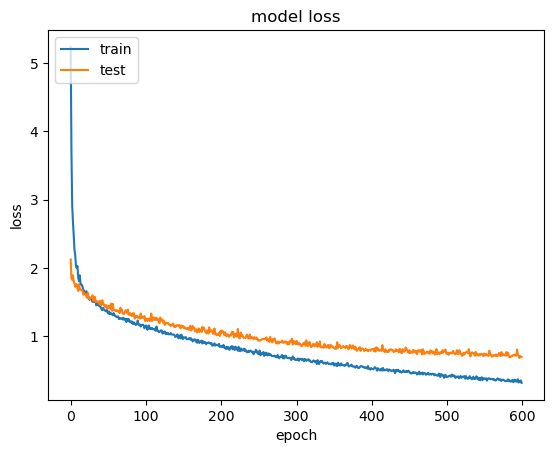

In [49]:
# Loss plotting
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

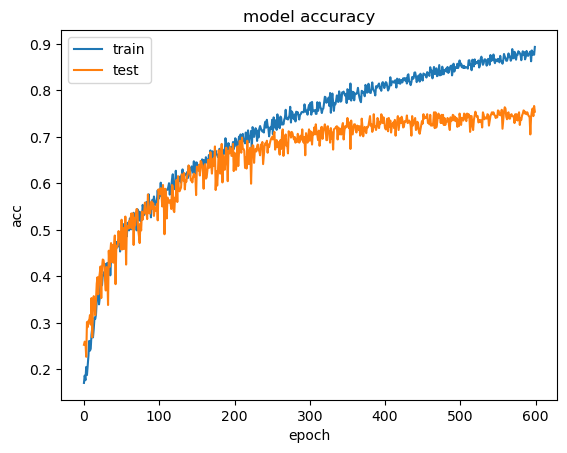

In [50]:
# Accuracy plotting
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
# Load Model
model = load_model('Audio_Sentiment_Model.h5')

In [51]:
# Make Predictions on all data
feature_df = pd.DataFrame(df['feature'].values.tolist())
x = np.expand_dims(feature_df, axis=2)
preds = model.predict(x)

77/77 [==============================] - 1s 18ms/step


We can have a look at which emotions are being wrongly guessed.

In [53]:
pred_labels = np.argmax(preds, axis=1)
pred_df = pd.DataFrame({'predictions':pred_labels})
result_df = pd.concat([df, pred_df], axis=1).drop('feature', axis=1)

# Count occurrences of each emotion
emotion_counts = result_df['emotion'].value_counts()

# Count occurrences of wrong predictions
wrong_predictions = result_df[result_df['emotion'] != result_df['predictions']]
wrong_prediction_counts = wrong_predictions['emotion'].value_counts()

# Create a new DataFrame for emotion, occurrences, and wrong predictions
counts_df = pd.DataFrame({'emotion': emotion_counts.index, 
                          'occurrences': emotion_counts.values, 
                          'wrong predictions': wrong_prediction_counts.values,
                          'percentage': wrong_prediction_counts.values / emotion_counts.values * 100})

counts_df['emotion'] = counts_df['emotion'].map(lambda x : get_emotion_str(x))
counts_df

,emotion,occurrences,wrong predictions,percentage
0,neutral,564,53,9.397163
1,sad,376,46,12.234043
2,fearful,376,34,9.042553
3,angry,376,31,8.244681
4,happy,376,30,7.978723
5,surprised,192,28,14.583333
6,digust,192,20,10.416667


We can look at which correct-wrong pairs are being guessed most.

In [54]:
# Count the occurrences of each 'actual-wrong' pair
correct_wrong_counts = wrong_predictions.groupby(['emotion', 'predictions']).size().reset_index(name='count')
correct_wrong_counts['emotion'] = correct_wrong_counts['emotion'].map(lambda x : get_emotion_str(x))
correct_wrong_counts['predictions'] = correct_wrong_counts['predictions'].map(lambda x : get_emotion_str(x))
correct_wrong_counts = correct_wrong_counts.sort_values(by=['emotion', 'count'], ascending=False)

correct_wrong_counts

,emotion,predictions,count
35,surprised,happy,13
34,surprised,neutral,5
39,surprised,digust,5
37,surprised,angry,4
38,surprised,fearful,3
36,surprised,sad,1
11,sad,neutral,11
14,sad,fearful,10
12,sad,happy,4
13,sad,angry,4


It looks like the fearful-sad pair occurs a lot. Perhaps we can understand better if we know if the emotion was normal or strong.

We can look at it predicts different emotions whether it was labelled as strong or normal.

In [ ]:
# TODO:

Additionally, we can see if there's an effect on the model whether the audio clip was speech or song.

In [ ]:
# TODO: